In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
from astral import LocationInfo
from astral.sun import daylight
from sklearn.kernel_ridge import KernelRidge

In [2]:
data = pd.read_parquet('../data/train.parquet')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [4]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [5]:
d = SchoolHolidayDates()
jf = JoursFeries()
data['hour'] = data.date.dt.hour
data['weekday'] = data.date.dt.weekday
data['dom'] = data.date.dt.day
data['week'] = data.date.dt.isocalendar().week
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year
# data['dom_counter'] = data.counter_installation_date.dt.day
# data['month_counter'] = data.counter_installation_date.dt.month
# data['year_counter'] = data.counter_installation_date.dt.year
data['date_datetime'] = data.date.map(lambda x: x.to_pydatetime().date())
# data['is_ferie'] = data.date_datetime.map(lambda x: jf.is_bank_holiday(x, zone='Métropole'))
# data['is_holiday'] = data.date_datetime.map(lambda x: d.is_holiday_for_zone(x, 'C'))

In [6]:
def is_daylight(x):
    city=LocationInfo('Paris', timezone='Europe/Paris')
    sun_info = daylight(city.observer, date=x.to_pydatetime().date(), tzinfo='Europe/Paris')
    x = x.tz_localize('Europe/Paris', ambiguous=True, nonexistent='shift_forward')
    return (x > sun_info[0]) & (x < sun_info[1])

In [7]:
data['is_daylight'] = data.date.map(is_daylight)

In [8]:
data.drop(columns=['counter_name', 'site_name', 'counter_technical_id', 'counter_installation_date'], inplace=True)

In [9]:
external_data = pd.read_csv("external_data_new.csv", parse_dates=['date'])

In [10]:
external_data

,date,2m.,Res.,Ros.,Vit.,Raf.3,Hum. [%],Visi. [Km],pluie_direct,pluie_intermittente,...,100057380-104057380,100057380-103057380,100057445-103057445,100057445-104057445,100060178-102060178,100060178-101060178,100063175-353277233,100063175-353277235,300014702-353245972,300014702-353245971
0,2020-09-01 00:00:00,13.9,13.9,9.7,3.7,7.4,76.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,True,True
1,2020-09-01 01:00:00,13.6,13.6,9.6,1.9,7.4,77.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,True,True
2,2020-09-01 02:00:00,13.0,13.0,9.4,1.9,7.4,79.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,True,True
3,2020-09-01 03:00:00,12.9,12.9,9.7,1.9,5.6,81.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,True,True
4,2020-09-01 04:00:00,12.4,12.4,9.6,3.7,5.6,83.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9859,2021-10-21 19:00:00,8.9,8.3,4.9,5.6,14.8,76.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,False,False
9860,2021-10-21 20:00:00,8.6,7.5,4.8,7.4,11.1,77.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,False,False
9861,2021-10-21 21:00:00,8.1,8.1,4.5,3.7,11.1,78.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,False,False
9862,2021-10-21 22:00:00,7.5,7.5,4.6,1.9,11.1,82.0,20.0,0.0,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
external_data = pd.read_csv("external_data_new.csv", parse_dates=['date'])
external_data_grouped = external_data.groupby(by=['date_datetime']).sum()
jours_feries = external_data_grouped.is_ferie > 0
jours_feries['2020-11-10'] = False
jours_feries['2020-11-11'] = True
holidays = external_data_grouped.is_holiday > 0
holidays['2020-11-10'] = False
holidays['2020-11-11'] = False
counters_list = data.counter_id.unique()
down_counters = external_data_grouped[counters_list] > 0
days_down={}
for counter in counters_list :
    string_list = down_counters[down_counters[counter] == True].index.values.tolist()
    date_datetime_list = [pd.to_datetime(j).date() for j in string_list]
    days_down[counter] = date_datetime_list

data['is_down'] = data.apply(lambda x: x.date_datetime in days_down[x.counter_id], axis=1)
# data = data[data['is_down'] == False]
data['is_ferie'] = data.date_datetime.map(lambda x: jours_feries[str(x)])
data['is_holiday'] = data.date_datetime.map(lambda x: holidays[str(x)])
data.drop(columns=['date_datetime'], inplace=True)

In [12]:
data

,counter_id,site_id,bike_count,date,latitude,longitude,log_bike_count,hour,weekday,dom,week,month,year,is_daylight,is_down,is_ferie,is_holiday
48321,100007049-102007049,100007049,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,2,1,1,36,9,2020,False,False,False,False
48324,100007049-102007049,100007049,1.0,2020-09-01 03:00:00,48.846028,2.375429,0.693147,3,1,1,36,9,2020,False,False,False,False
48327,100007049-102007049,100007049,0.0,2020-09-01 04:00:00,48.846028,2.375429,0.000000,4,1,1,36,9,2020,False,False,False,False
48330,100007049-102007049,100007049,4.0,2020-09-01 15:00:00,48.846028,2.375429,1.609438,15,1,1,36,9,2020,True,False,False,False
48333,100007049-102007049,100007049,9.0,2020-09-01 18:00:00,48.846028,2.375429,2.302585,18,1,1,36,9,2020,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,300014702,51.0,2021-08-08 18:00:00,48.839770,2.301980,3.951244,18,6,8,31,8,2021,True,False,False,True
928453,300014702-353245971,300014702,1.0,2021-08-09 02:00:00,48.839770,2.301980,0.693147,2,0,9,32,8,2021,False,False,False,True
928456,300014702-353245971,300014702,61.0,2021-08-09 08:00:00,48.839770,2.301980,4.127134,8,0,9,32,8,2021,True,False,False,True
928459,300014702-353245971,300014702,44.0,2021-08-09 10:00:00,48.839770,2.301980,3.806662,10,0,9,32,8,2021,True,False,False,True


In [13]:
external_data.columns

Index(['date', '2m.', 'Res.', 'Ros.', 'Vit.', 'Raf.3', 'Hum. [%]',
       'Visi. [Km]', 'pluie_direct', 'pluie_intermittente',
       ...
       '100057380-104057380', '100057380-103057380', '100057445-103057445',
       '100057445-104057445', '100060178-102060178', '100060178-101060178',
       '100063175-353277233', '100063175-353277235', '300014702-353245972',
       '300014702-353245971'],
      dtype='object', length=138)

In [14]:
external_data.cl = external_data.cl.fillna(value=100)
external_data.cm = external_data.cm.fillna(value=100)
external_data.ch = external_data.ch.fillna(value=100)
external_data.ssfrai = external_data.ssfrai.fillna(value=0.0)
external_data.perssfrai = external_data.perssfrai.fillna(value=0.0)
external_data.dropna(axis=1, thresh=6000, inplace=True)
external_data.drop(columns=counters_list, inplace=True)
external_data.drop(columns=['numer_sta', 'per', 'pres', 'is_ferie', 'is_holiday', 'nnuage1', 'ctype1', 'hnuage1'], inplace=True)
external_data.fillna(method='ffill', inplace=True)

In [15]:
external_data

,date,2m.,Res.,Ros.,Vit.,Raf.3,Hum. [%],Visi. [Km],pluie_direct,pluie_intermittente,...,rafper,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24
0,2020-09-01 00:00:00,13.9,13.9,9.7,3.7,7.4,76.0,20.0,0.0,False,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
1,2020-09-01 01:00:00,13.6,13.6,9.6,1.9,7.4,77.0,20.0,0.0,False,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2,2020-09-01 02:00:00,13.0,13.0,9.4,1.9,7.4,79.0,20.0,0.0,False,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
3,2020-09-01 03:00:00,12.9,12.9,9.7,1.9,5.6,81.0,20.0,0.0,False,...,1.5,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0
4,2020-09-01 04:00:00,12.4,12.4,9.6,3.7,5.6,83.0,20.0,0.0,False,...,1.5,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9859,2021-10-21 19:00:00,8.9,8.3,4.9,5.6,14.8,76.0,20.0,0.0,False,...,13.2,1.0,0.0,0.0,-60.0,0.6,0.6,0.6,0.6,2.6
9860,2021-10-21 20:00:00,8.6,7.5,4.8,7.4,11.1,77.0,20.0,0.0,False,...,13.2,1.0,0.0,0.0,-60.0,0.6,0.6,0.6,0.6,2.6
9861,2021-10-21 21:00:00,8.1,8.1,4.5,3.7,11.1,78.0,20.0,0.0,False,...,13.2,1.0,0.0,0.0,-60.0,0.6,0.6,0.6,0.6,2.6
9862,2021-10-21 22:00:00,7.5,7.5,4.6,1.9,11.1,82.0,20.0,0.0,False,...,13.2,1.0,0.0,0.0,-60.0,0.6,0.6,0.6,0.6,2.6


In [16]:
ext_index = external_data.set_index('date')

In [17]:
ext_index.sort_index(inplace=True)

In [18]:
ext_index

,2m.,Res.,Ros.,Vit.,Raf.3,Hum. [%],Visi. [Km],pluie_direct,pluie_intermittente,pluie_continue,...,rafper,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,13.9,13.9,9.7,3.7,7.4,76.0,20.0,0.0,False,False,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,13.6,13.6,9.6,1.9,7.4,77.0,20.0,0.0,False,False,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 02:00:00,13.0,13.0,9.4,1.9,7.4,79.0,20.0,0.0,False,False,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 03:00:00,12.9,12.9,9.7,1.9,5.6,81.0,20.0,0.0,False,False,...,1.5,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 04:00:00,12.4,12.4,9.6,3.7,5.6,83.0,20.0,0.0,False,False,...,1.5,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-21 19:00:00,8.9,8.3,4.9,5.6,14.8,76.0,20.0,0.0,False,False,...,13.2,1.0,0.0,0.0,-60.0,0.6,0.6,0.6,0.6,2.6
2021-10-21 20:00:00,8.6,7.5,4.8,7.4,11.1,77.0,20.0,0.0,False,False,...,13.2,1.0,0.0,0.0,-60.0,0.6,0.6,0.6,0.6,2.6
2021-10-21 21:00:00,8.1,8.1,4.5,3.7,11.1,78.0,20.0,0.0,False,False,...,13.2,1.0,0.0,0.0,-60.0,0.6,0.6,0.6,0.6,2.6


In [19]:
data_index = data.set_index('date')
data_index.sort_index(inplace=True)

In [20]:
merged_data = pd.merge_asof(data_index, ext_index, left_index=True, right_index=True)

In [21]:
merged_data

,counter_id,site_id,bike_count,latitude,longitude,log_bike_count,hour,weekday,dom,week,...,rafper,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 01:00:00,100056332-104056332,100056332,0.0,48.83848,2.37587,0.000000,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,100047547-104047547,100047547,4.0,48.82636,2.30303,1.609438,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,100047547-103047547,100047547,2.0,48.82636,2.30303,1.098612,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,100057380-103057380,100057380,0.0,48.86462,2.31444,0.000000,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
2020-09-01 01:00:00,100047548-103047548,100047548,2.0,48.89141,2.38482,1.098612,1,1,1,36,...,3.1,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-09 23:00:00,100057329-103057329,100057329,16.0,48.84201,2.36729,2.833213,23,0,9,32,...,4.1,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1
2021-08-09 23:00:00,100060178-101060178,100060178,7.0,48.84638,2.31529,2.079442,23,0,9,32,...,4.1,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1
2021-08-09 23:00:00,100056335-104056335,100056335,8.0,48.86288,2.31179,2.197225,23,0,9,32,...,4.1,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,-0.1


In [22]:
merged_data['is_confinement_1'] = (merged_data.date_datetime > '2020-10-17') & (merged_data.date_datetime < '2020-12-15')
merged_data['commerce_fermes_20'] = (merged_data.date_datetime > '2020-10-17') & (merged_data.date_datetime < '2020-11-28')
merged_data['couvre_feu_20'] = (merged_data.date_datetime > '2020-12-14') & (merged_data.date_datetime < '2021-01-17')
merged_data['couvre_feu_18'] = ((merged_data.date_datetime > '2021-01-16') & (merged_data.date_datetime < '2021-03-20')) | ((merged_data.date_datetime > '2021-05-02') & (merged_data.date_datetime < '2021-05-19'))
merged_data['is_confinement_2'] = (merged_data.date_datetime > '2021-03-19') & (merged_data.date_datetime < '2021-04-03')
merged_data['is_confinement_3'] = (merged_data.date_datetime > '2021-04-02') & (merged_data.date_datetime < '2021-05-03')
merged_data['couvre_feu_21'] = (merged_data.date_datetime > '2021-18-05') & (merged_data.date_datetime < '2021-09-06')
merged_data['couvre_feu_23'] = (merged_data.date_datetime > '2021-08-06') & (merged_data.date_datetime < '2021-21-06')

<AxesSubplot:xlabel='date_datetime', ylabel='t'>

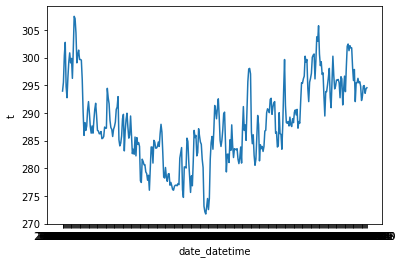

In [23]:
# checking if the temperature values make sens after the merge
merged_grouped =merged_data.groupby(by='date_datetime').t.max()
sns.lineplot(data=merged_grouped)

In [24]:
feature = merged_data.drop(columns=['bike_count', 'log_bike_count', 'date_datetime'])
target = merged_data['log_bike_count']

In [25]:
feature.columns

Index(['counter_id', 'site_id', 'latitude', 'longitude', 'hour', 'weekday',
       'dom', 'week', 'month', 'year', 'is_daylight', 'is_down', 'is_ferie',
       'is_holiday', '2m.', 'Res.', 'Ros.', 'Vit.', 'Raf.3', 'Hum. [%]',
       'Visi. [Km]', 'pluie_direct', 'pluie_intermittente', 'pluie_continue',
       'pluie_forte', 'pluie_faible', 'pluie_modérée', 'neige', 'bruine',
       'brouillard', 'verglas', 'temps_soleil', 'pluie_cumul', 'vent_max',
       'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww',
       'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'tend24', 'raf10',
       'rafper', 'etat_sol', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3',
       'rr6', 'rr12', 'rr24', 'is_confinement_1', 'commerce_fermes_20',
       'couvre_feu_20', 'couvre_feu_18', 'is_confinement_2',
       'is_confinement_3', 'couvre_feu_21', 'couvre_feu_23'],
      dtype='object')

In [26]:
feature.ww.nunique()

42

In [27]:
feature.drop(columns=['pmer', 'tend', 'cod_tend', 'dd', 'ff', 'td', 'vv', 'ww', 'w1', 'w2', 'tend24', 'ssfrai', 'perssfrai', 'etat_sol', 'hbas', 'nbas', 'u', 'n'], inplace=True)

In [28]:
categorical_columns = ['counter_id', 'site_id', 'is_ferie', 'is_holiday', 'is_confinement_1', 'is_confinement_2', 'commerce_fermes_20', 'couvre_feu_20', 'couvre_feu_18', 'is_confinement_3', 'couvre_feu_21', 'couvre_feu_23', 'hour', 'weekday', 'month', 'year', 'is_daylight', 'cl', 'cm', 'ch', 'pluie_direct', 'pluie_intermittente', 'pluie_continue', 'pluie_forte', 'pluie_faible', 'pluie_modérée', 'neige', 'bruine', 'brouillard', 'verglas']
numerical_columns = [col for col in feature.columns if col not in categorical_columns]

In [29]:
categories = []
for col in categorical_columns :
    cats = feature[col].unique()
    if np.issubdtype(type(cats[0]), np.number):
        cats.sort()
    categories.append(cats)

categories

[['100056332-104056332', '100047547-104047547', '100047547-103047547', '100057380-103057380', '100047548-103047548', ..., '100056336-106056336', '100056226-104056226', '100056226-103056226', '300014702-353245971', '300014702-353245972']
 Length: 56
 Categories (56, object): ['100007049-101007049', '100007049-102007049', '100036718-103036718', '100036718-104036718', ..., '100063175-353277233', '100063175-353277235', '300014702-353245971', '300014702-353245972'],
 array([100007049, 100036718, 100036719, 100042374, 100044493, 100047542,
        100047545, 100047546, 100047547, 100047548, 100049407, 100050876,
        100056046, 100056047, 100056223, 100056226, 100056327, 100056329,
        100056330, 100056331, 100056332, 100056334, 100056335, 100056336,
        100057329, 100057380, 100057445, 100060178, 100063175, 300014702],
       dtype=int64),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True])

In [109]:
preprocessor_deep = ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories=categories, drop='first', sparse=False, handle_unknown='ignore'), categorical_columns),
                                ('standard_scaler', StandardScaler(), numerical_columns)])

In [110]:
preprocessor_deep.fit_transform(feature).shape

(455163, 221)

In [111]:
inputs = keras.Input(shape=(221, ))
dense = layers.Dense(256, activation='relu')
x = dense(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)

In [112]:
model = keras.Model(inputs=inputs, outputs=outputs, name='bikes_deep')
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "bikes_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 221)]             0         
                                                                 
 dense_8 (Dense)             (None, 256)               56832     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 98,049
Trainable params: 98,049
Non-trainable params: 0
_________________________________________________________________


In [30]:
features_train, features_test, target_train, target_test = train_test_split(feature, target, shuffle=False, train_size=0.8)

In [114]:
pipe = make_pipeline(preprocessor_deep, model)

In [115]:
pipe.fit(features_train, target_train, functional__validation_split=0.2, functional__epochs=20, functional__batch_size=1000, functional__shuffle=False)

Epoch 1/20
292/292 [==============================] - 1s 4ms/step - loss: 1.6129 - val_loss: 0.8340
Epoch 2/20
292/292 [==============================] - 1s 3ms/step - loss: 0.6413 - val_loss: 0.7406
Epoch 3/20
292/292 [==============================] - 1s 4ms/step - loss: 0.5061 - val_loss: 0.8880
Epoch 4/20
292/292 [==============================] - 1s 4ms/step - loss: 0.4939 - val_loss: 0.8855
Epoch 5/20
292/292 [==============================] - 1s 4ms/step - loss: 0.4505 - val_loss: 0.9373
Epoch 6/20
292/292 [==============================] - 1s 4ms/step - loss: 0.4615 - val_loss: 0.7947
Epoch 7/20
292/292 [==============================] - 1s 4ms/step - loss: 0.5010 - val_loss: 0.6375
Epoch 8/20
292/292 [==============================] - 1s 4ms/step - loss: 0.4099 - val_loss: 0.6584
Epoch 9/20
292/292 [==============================] - 1s 4ms/step - loss: 0.3672 - val_loss: 1.7250
Epoch 10/20
292/292 [==============================] - 1s 4ms/step - loss: 0.4232 - val_loss: 2.8688

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(categories=[['100056332-104056332', '100047547-104047547', '100047547-103047547', '100057380-103057380', '100047548-103047548', ..., '100056336-106056336', '100056226-104056226', '100056226-103056226', '300014702-353245971', '300014702-353245972']
Length: 56
Ca...
                                                   'bruine', 'brouillard',
                                                   'verglas']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'dom', 'week', 'is_down',
                                                   '2m.', 'Res.', 'Ros.',
                                                   'Vit.', 'R

In [116]:
preds = pipe.predict(features_test)
score = mean_squared_error(target_test, preds, squared=False)
print(score)

1.654289577556638


In [35]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

def build_model():
    inputs = keras.Input(shape=(176, ))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='bikes_deep')
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [37]:
model = KerasRegressor(build_model, validation_split=0.2, epochs=10, batch_size=1000, shuffle=False)

C:\Users\natha\AppData\Local\Temp/ipykernel_28992/3901342833.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_model, validation_split=0.2, epochs=10, batch_size=1000, shuffle=False)


In [38]:
pipe_deep = make_pipeline(preprocessor_deep, model)
pipe_deep.fit(features_train, target_train)

Epoch 1/10
288/288 [==============================] - 2s 5ms/step - loss: 1.8603 - val_loss: 0.9201
Epoch 2/10
288/288 [==============================] - 1s 5ms/step - loss: 0.7539 - val_loss: 1.4966
Epoch 3/10
288/288 [==============================] - 1s 5ms/step - loss: 0.6562 - val_loss: 1.2108
Epoch 4/10
288/288 [==============================] - 1s 4ms/step - loss: 0.5413 - val_loss: 0.7807
Epoch 5/10
288/288 [==============================] - 1s 4ms/step - loss: 0.4780 - val_loss: 0.6114
Epoch 6/10
288/288 [==============================] - 1s 4ms/step - loss: 0.4638 - val_loss: 0.5858
Epoch 7/10
288/288 [==============================] - 1s 4ms/step - loss: 0.4272 - val_loss: 0.8047
Epoch 8/10
288/288 [==============================] - 1s 4ms/step - loss: 0.3850 - val_loss: 1.0442
Epoch 9/10
288/288 [==============================] - 1s 5ms/step - loss: 0.3629 - val_loss: 1.3290
Epoch 10/10
288/288 [==============================] - 1s 4ms/step - loss: 0.3623 - val_loss: 1.3762

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(categories=[['100057445-103057445', '100057329-103057329', '100060178-102060178', '100056332-103056332', '100056335-104056335', ..., '100056336-106056336', '100056335-103056335', '100063175-353277235', '300014702-353245971', '300014702-353245972']
Length: 56
Ca...
                                                   'is_ferie', 'is_holiday',
                                                   'is_confinement_1',
                                                   'is_confinement_2', 'hour',
                                                   'weekday', 'month', 'year',
                                                   'is_daylight', 'cl', 'cm',
                                                   'ch']),
                                                 ('standard_scaler',
                                                  St

In [39]:
preds = pipe_deep.predict(features_test)
mean_squared_error(preds, target_test, squared=False)

1.305273777936534

In [31]:
from sklearn.linear_model import Ridge

tss = TimeSeriesSplit()
cv = tss.split(features_train)

preprocessor = ColumnTransformer([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_columns),
                                    ('standard_scaler', StandardScaler(), numerical_columns)])

pipe_ridge = make_pipeline(preprocessor, Ridge(alpha=6))

pipe_ridge.fit(features_train, target_train)

preds = pipe_ridge.predict(features_test)

print(mean_squared_error(target_test, preds, squared=False))

0.8223885609586173


In [41]:
from sklearn.tree import DecisionTreeRegressor

tss = TimeSeriesSplit()
cv = tss.split(features_train)

pipe_tree = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=30, min_samples_leaf=40))

params = {'decisiontreeregressor__max_features' : ['sqrt', None],
            'decisiontreeregressor__min_samples_split': [2, 10, 20]}

gcv = GridSearchCV(pipe_tree, param_grid=params, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=4)
gcv.fit(features_train, target_train)
gcv.best_params_

{'decisiontreeregressor__max_features': None,
 'decisiontreeregressor__min_samples_split': 20}

In [42]:
gcv.score(features_test, target_test)

-0.8233746072506805

In [43]:
from sklearn.ensemble import RandomForestRegressor

pipe_forest = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, max_samples=50000, max_depth=10, min_samples_leaf=10))
pipe_forest.fit(features_train, target_train)

preds = pipe_forest.predict(features_test)

print(mean_squared_error(preds, target_test, squared=False))

0.9572901362301225


In [33]:
from sklearn.ensemble import HistGradientBoostingRegressor

tss = TimeSeriesSplit()
cv = tss.split(features_train)

regressor = HistGradientBoostingRegressor(max_depth=30, min_samples_leaf=50, l2_regularization=20)

pipe_hist = make_pipeline(preprocessor, regressor)

params = {'histgradientboostingregressor__max_iter': [1000]}

gcv = GridSearchCV(pipe_hist, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=4, cv=cv)

gcv.fit(features_train, target_train)

print(gcv.best_params_)

{'histgradientboostingregressor__max_iter': 1000}


In [34]:
gcv.score(features_test, target_test)

-0.645043888352365

In [120]:
pipe_hist.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'histgradientboostingregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__one_hot_encoder', 'columntransformer__standard_scaler', 'columntransformer__one_hot_encoder__categories', 'columntransformer__one_hot_encoder__drop', 'columntransformer__one_hot_encoder__dtype', 'columntransformer__one_hot_encoder__handle_unknown', 'columntransformer__one_hot_encoder__sparse', 'columntransformer__standard_scaler__copy', 'columntransformer__standard_scaler__with_mean', 'columntransformer__standard_scaler__with_std', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learni

In [32]:
from xgboost import XGBRegressor

tss = TimeSeriesSplit()
cv = tss.split(features_train)

pipe_xgb = make_pipeline(preprocessor, XGBRegressor(max_depth=30, min_samples_leaf=50))

# params = {'xgbregressor__n_estimators' : [200, 400]}

# gcv = GridSearchCV(pipe_xgb, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=8, cv=cv)

pipe_xgb.fit(features_train, target_train)

# print(gcv.best_params_)

# print(-gcv.score(features_test, target_test))

preds = pipe_xgb.predict(features_test)

print(mean_squared_error(target_test, preds, squared=False))

0.6864134254711827


In [48]:
pipe_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'xgbregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__one_hot_encoder', 'columntransformer__standard_scaler', 'columntransformer__one_hot_encoder__categories', 'columntransformer__one_hot_encoder__drop', 'columntransformer__one_hot_encoder__dtype', 'columntransformer__one_hot_encoder__handle_unknown', 'columntransformer__one_hot_encoder__sparse', 'columntransformer__standard_scaler__copy', 'columntransformer__standard_scaler__with_mean', 'columntransformer__standard_scaler__with_std', 'xgbregressor__objective', 'xgbregressor__base_score', 'xgbregressor__booster', 'xgbregressor__colsample_bylevel', 'xgbregressor__colsample_bynode', 'xgbregressor__colsample_bytree', 'xgbregressor__enable_catego

In [49]:
XGBRegressor?

Init signature:
XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : typing.Union[str, typing.Callable[[numpy.ndarray, numpy.ndarray], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: Optional[str]
        

In [47]:
gcv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_xgbregressor__max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])